In [1]:
import pymysql
import pickle
import json

import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'

import time
import hdbscan

import spacy
from gensim.models import Word2Vec

In [2]:
PMIDs_dir = '/home/brendan/FastData/pubmed2019/pubmed_data_processing/year_pmids/'
PMIDs_name = 'pubmed_state_2008'  # these should have a .json postfix
PMIDs_path = PMIDs_dir + PMIDs_name

with open(PMIDs_path, 'r') as f:
    data = json.load(f)

K = 100000  #  for testing - number of pmids to subselect
PMIDs = data['publications'][:K] # testing, just grab the first K non-randomly
print("N PMIDs: {}".format(len(PMIDs)))

N PMIDs: 100000


### mysql control parameters

In [3]:
db_name = 'test_pubmed'  # db name collisons? https://stackoverflow.com/questions/14011968/user-cant-access-a-database
config_path = '/home/brendan/Projects/AttentionWildfires/attention_wildfires/mysql_config.json'

with open(config_path, 'r') as f:
    config_data = json.load(f)
    
client_config = {'database': db_name,
                'user': config_data['user'],
                 'password': config_data['lock']}

db = pymysql.connect(**client_config)

##  build a training set from selected pmids

In [4]:
str_fmt = ', '.join([str(pmid) for pmid in PMIDs])

sql = '''SELECT A.title, A.abstract
        FROM abstracts as A
        WHERE A.pmid IN ({})'''.format(str_fmt)

start_time = time.time()
cursor = db.cursor()
cursor.execute(sql)
end_time = time.time()
elapsed = end_time - start_time
print("SQL join executed in {} s".format(elapsed))

start_time = time.time()
titles = []
abstracts = []
for i,row in enumerate(cursor):
    print_block_len = 100000
    if (i+1) % print_block_len == 0:
        print('fetched {} rows...'.format(print_block_len))
    titles.append(row[0])
    abstracts.append(row[1])
cursor.close()
end_time = time.time()
elapsed = end_time - start_time
print("SQL results fetched and cast in {} s".format(elapsed))


SQL join executed in 71.5970196723938 s
SQL results fetched and cast in 0.10697603225708008 s


In [5]:
'''
lang = "en"
pipeline = ["tagger", "parser", "ner"]
data_path = "path/to/en_core_web_sm/en_core_web_sm-2.0.0"

nlp = PyTT_Language(pytt_name=name, meta={"lang": "en"})
nlp.add_pipe(nlp.create_pipe("sentencizer"))

abstracts_sentencized = nlp(abstracts)

print(abstracts_sentencized[:10])
'''
# todo do this with scispacy

'\nlang = "en"\npipeline = ["tagger", "parser", "ner"]\ndata_path = "path/to/en_core_web_sm/en_core_web_sm-2.0.0"\n\nnlp = PyTT_Language(pytt_name=name, meta={"lang": "en"})\nnlp.add_pipe(nlp.create_pipe("sentencizer"))\n\nabstracts_sentencized = nlp(abstracts)\n\nprint(abstracts_sentencized[:10])\n'

In [6]:
# how should the corpus be formatted?
import random
import re

corpus = []
for t,a in zip(titles, abstracts):
    
    P_ = t +  ' ' + a   # note, there is already a period at the end of the title
    # todo consider segmenting sentences - currently title and abstract are one long sample
    
    p_ = P_.lower()
    p = re.sub(r'[^\w\s]','',p_)  # todo check this
        #  todo entities? lemmatization? other preprocessing?
    # todo number string matching
    #   todo use significant digits to decide on the mask
    p_clean = re.sub(r'[ ][+-]?[\d]+',' <NUM>', p) # '^[-+]?[\d]$","\n",p) #  substitute numbers
    
    words_clean = str.split(p_clean,' ')
    corpus.append(words_clean)
    
print(corpus[:1])
print(len(corpus))



[['editorial', '']]
99388


In [7]:
# todo split into sentences first--
''' 
# todo modify this code to take the title + abstract paragraphs into sentences
'''
#name = "scibert-scivocab-uncased"
#path = "/project2/jevans/brendan/pretrained_transformers/scibert-scivocab-uncased"  # todo bring to k-g
#path = "/home/brendan/FastData/pretrained_transformers/scibert-scivocab-uncased"
# https://github.com/allenai/scibert
#  https://arxiv.org/abs/1903.10676

#nlp = PyTT_Language(pytt_name=name, meta={"lang": "en"})
#nlp.add_pipe(nlp.create_pipe("sentencizer"))
#nlp.add_pipe(PyTT_WordPiecer.from_pretrained(nlp.vocab, path))  # consider using the vocabulary-set of the scibert model?


' \n# todo modify this code to take the title + abstract paragraphs into sentences\n'

In [8]:
# train word2vec components

start_time = time.time()

model = Word2Vec(corpus, size=20, window=5, min_count=10, workers=4)

end_time = time.time()
print("elapsed: {}".format(end_time - start_time))


elapsed: 60.69626307487488


In [9]:
# save the word2vec networks

model.save("test_word2vec.model")   # could just save the .kv file instead

In [10]:
# load the model and test

model_test = Word2Vec.load("test_word2vec.model")


#  get params
vocab_size = len(model_test.wv.vocab)
D = np.shape(model_test.wv['and'])[0]
print(vocab_size, D)


49715 20


In [11]:
#  try to visualize the wordnet

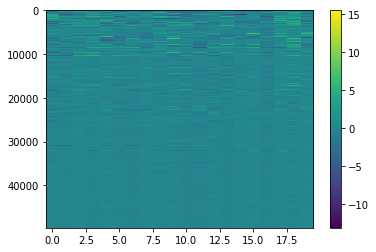

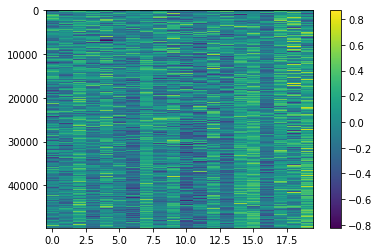

In [12]:
# step 1 populate matrix with normalized coordinates

word_matrix_raw = np.zeros((vocab_size, D))
word_list = []

for idx,word in enumerate(model_test.wv.vocab):
    word_list.append(word)
    word_matrix_raw[idx,:] = model_test.wv[word]

plt.figure()
plt.imshow(word_matrix_raw, aspect='auto')
plt.colorbar()

# normalize rows of the matrix
word_matrix = word_matrix_raw
row_norms = np.linalg.norm(word_matrix_raw, ord=2, axis=1)
for i_row, row_norm in enumerate(row_norms):
    word_matrix[i_row,:] /= row_norm

plt.figure()
plt.imshow(word_matrix, aspect='auto')
plt.colorbar()


In [13]:
# determine a threshold for word similarity

full_similarity_matrix = np.matmul(word_matrix, word_matrix.T)


(array([2.0000000e+00, 0.0000000e+00, 1.8000000e+01, 6.2000000e+01,
        2.4000000e+02, 7.3800000e+02, 1.6000000e+03, 3.5960000e+03,
        7.6440000e+03, 1.3994000e+04, 2.4858000e+04, 4.1634000e+04,
        6.6408000e+04, 1.0350800e+05, 1.5447400e+05, 2.2663000e+05,
        3.2300000e+05, 4.4749600e+05, 6.1081800e+05, 8.1779400e+05,
        1.0753420e+06, 1.3905180e+06, 1.7776180e+06, 2.2404320e+06,
        2.7895700e+06, 3.4455400e+06, 4.1960700e+06, 5.0705340e+06,
        6.0644880e+06, 7.1944980e+06, 8.4536360e+06, 9.8851620e+06,
        1.1454484e+07, 1.3163764e+07, 1.5025702e+07, 1.7037258e+07,
        1.9171502e+07, 2.1431534e+07, 2.3804892e+07, 2.6268272e+07,
        2.8824412e+07, 3.1396040e+07, 3.4001714e+07, 3.6612354e+07,
        3.9194420e+07, 4.1733902e+07, 4.4187004e+07, 4.6565992e+07,
        4.8838116e+07, 5.0943944e+07, 5.2935362e+07, 5.4780548e+07,
        5.6442912e+07, 5.7962178e+07, 5.9293070e+07, 6.0426448e+07,
        6.1394546e+07, 6.2149568e+07, 6.2769412e

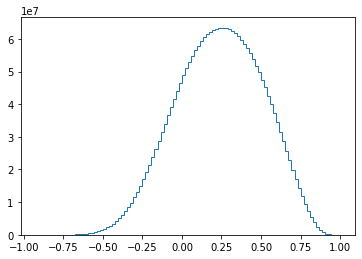

In [14]:
plt.figure()
plt.hist(full_similarity_matrix.flatten(), bins=100, histtype='step')

In [15]:
word_similarity_scores = full_similarity_matrix.flatten()
upper_thresh = np.percentile(word_similarity_scores,99.9)
lower_thresh = np.percentile(word_similarity_scores,0.1)
del word_similarity_scores

print(upper_thresh, lower_thresh)

0.8683108306438085 -0.5466990303550286


In [18]:
edges = []

for i_row, row in enumerate(full_similarity_matrix):
    for i_col, score in enumerate(row):
        if score > upper_thresh or score <= lower_thresh:
            row_word = word_list[i_row]
            col_word = word_list[i_col]
            edges.append( (row_word, col_word, score))


In [19]:
print(len(edges))

4943165


In [21]:
with open('data_processing/test_edgelist.json','w') as f:
    json.dump(edges, f)